In [25]:
#Import Modules
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from scipy.stats import ttest_ind
plt.rcParams["figure.figsize"] = [14, 10]
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# Reflect Tables into SQLAlchemy ORM

In [26]:
#Define SQLite Database Engine
engine = create_engine("sqlite:///Hawaii_Climate_Data/hawaii.sqlite")

In [27]:
#Map Database from SQLite File
Base = automap_base()

#Import Tables from Database
Base.prepare(engine, reflect=True)

In [28]:
#Display Class Names
Base.classes.keys()

['measurement', 'station']

In [29]:
#Define Classes as Table Names
Measurement = Base.classes.measurement
Station = Base.classes.station

In [30]:
#Create Session Link to SQLite Database
session = Session(engine)

# Exploratory Climate Analysis

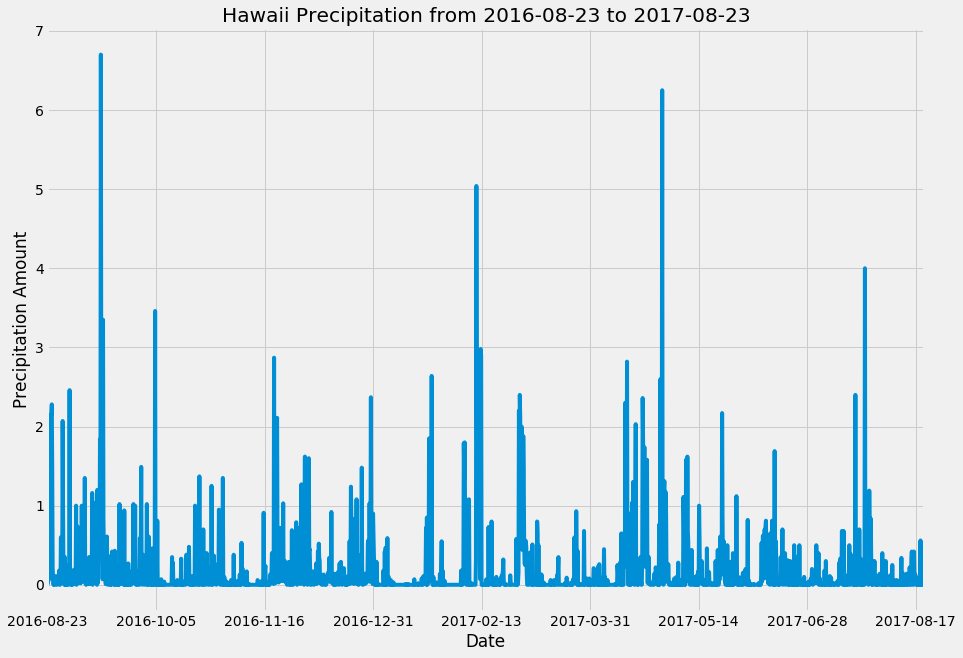

In [31]:
#Extract All Avialable Dates from Measurements Table
date_list = engine.execute('SELECT date FROM Measurement')

#Loop Thruough Dates to Find Latest Record
for date in date_list:
    last_date = date[0]
    
#Split Lastest Date Record at Dashes to Isolate Year/Month/Day
date_split = last_date.split('-')

#Subtract One from Year Index
date_split[0] = str(int(date_split[0]) - 1)

#Re-Assemble Date Value & Record as Year Prior Date
prior_date = date_split[0] + '-' + date_split[1] + '-' + date_split[2]

#Query Database to Create Pandas Data Frame of Precipitation Data for Selected Year-Long Period
precip_data = pd.read_sql('SELECT date, prcp FROM Measurement WHERE date >= (?)', engine, params = (prior_date,))

#Drop Rows with Missing Values
precip_data = precip_data.dropna()

#Set Date Values as Data Frame Index
precip_data = precip_data.set_index('date')

#Sort Data Frame by Date
precip_data = precip_data.sort_index()

#Plot Bar Chart of Precipitation History for Selected Year
precip_data.plot(legend = None)
plt.xlabel('Date')
plt.ylabel('Precipitation Amount')
plt.title('Hawaii Precipitation from ' + prior_date + ' to ' + last_date)
plt.show()

In [32]:
#Calculate Summary Statistics for Precipitation Data
precip_count = precip_data.count()
precip_mean = precip_data.mean()
precip_std = precip_data.std()
precip_min = precip_data.min()
precip_first = precip_data.quantile(0.25)
precip_second = precip_data.quantile(0.5)
precip_third = precip_data.quantile(0.75)
precip_max = precip_data.max()

#Create Data Frame of Precipitation Data Summary Statistics
precip_summary = pd.DataFrame({'precipitation': [precip_count[0], precip_mean[0], precip_std[0], precip_min[0],
                                                 precip_first[0], precip_second[0], precip_third[0], precip_max[0]]},
                              index = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])

precip_summary

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [33]:
#Extract Unique Weather Station IDs from Database
unique_stations = engine.execute('SELECT COUNT(DISTINCT station) FROM Station')

#Display Unique Weather Station Count
for count in unique_stations:
    print(count)

(9,)


In [34]:
#Extract Weather Station Activity from Database & Sort in Descending Order
active_stations = engine.execute('SELECT Measurement.station, Station.name, COUNT(Measurement.station) AS station_occurence FROM Measurement INNER JOIN Station ON Station.station = Measurement.station GROUP BY Measurement.station ORDER BY station_occurence DESC')

#Display List of Weather Stations from Most Active to Least Active
for occurences in active_stations:
    print(occurences)

('USC00519281', 'WAIHEE 837.5, HI US', 2772)
('USC00519397', 'WAIKIKI 717.2, HI US', 2724)
('USC00513117', 'KANEOHE 838.1, HI US', 2709)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979)
('USC00517948', 'PEARL CITY, HI US', 1372)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)


In [35]:
#Extract Maximum/Minimum/Average Temperature Data from Database for Most Active Weather Station
busiest_station = engine.execute('SELECT MAX(tobs) as max_temp, MIN(tobs) as min_temp, AVG(tobs) as avg_temp FROM Measurement WHERE station = :busiest', busiest = 'USC00519281')

#Display Maximum/Minimum/Average Temperature Data for Most Active Weather Station
for stats in busiest_station:
    print(stats)

(85.0, 54.0, 71.66378066378067)


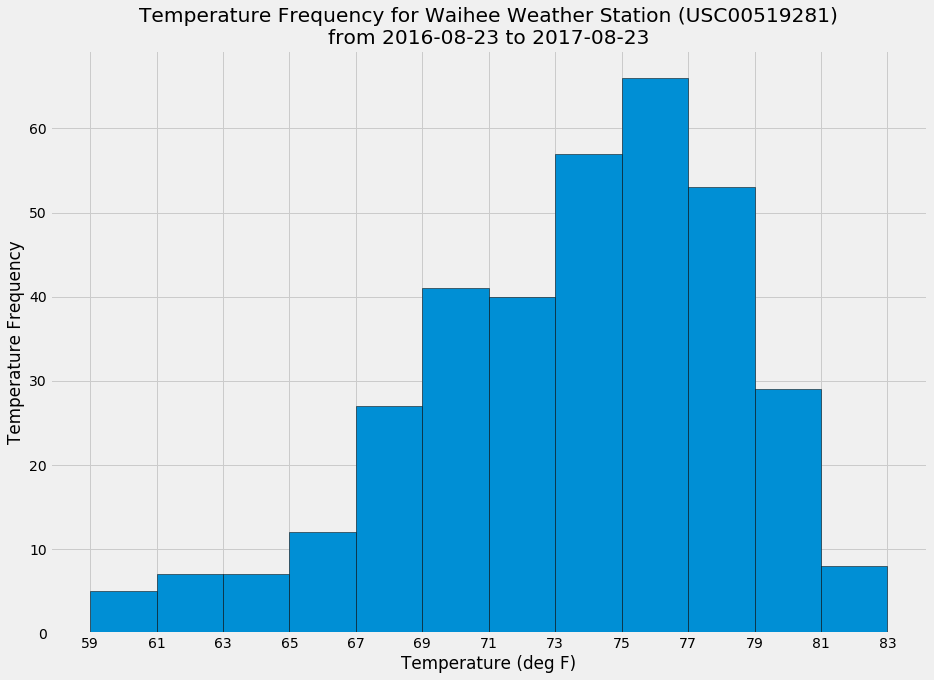

In [36]:
#Query Database to Create Pandas Data Frame of Temperature Data for Selected Year-Long Period for Most Active Weather Station
temp_data = pd.read_sql('SELECT date, tobs FROM Measurement WHERE date >= (?) AND station = (?)', engine, params = (prior_date, 'USC00519281',))

#Drop Rows with Missing Values
temp_data = temp_data.dropna()

#Set Date Values as Data Frame Index
temp_data = temp_data.set_index('date')

#Sort Data Frame by Date
temp_data = temp_data.sort_index()

#Create Twelve Equal Sized Bins of Temper
temp_hist, temp_bins = np.histogram(temp_data['tobs'], bins = 12)

plt.bar(temp_bins[:-1] + 1, temp_hist, width = 2, edgecolor = 'black')
plt.xticks(temp_bins)
plt.title('Temperature Frequency for Waihee Weather Station (USC00519281)\nfrom ' + prior_date + ' to ' + last_date)
plt.xlabel('Temperature (deg F)')
plt.ylabel('Temperature Frequency')
plt.show()

# Temperature Analysis

In [37]:
#Query Database to Create Pandas Data Frame of June Temperature Data
june_temps = pd.read_sql('SELECT date, tobs, strftime("%m", date) as month FROM Measurement WHERE month = "06"', engine)

#Display Data Frame of June Temperature Data
june_temps

,date,tobs,month
0,2010-06-01,78.0,06
1,2010-06-02,76.0,06
2,2010-06-03,78.0,06
3,2010-06-04,76.0,06
4,2010-06-05,77.0,06
5,2010-06-06,78.0,06
6,2010-06-07,77.0,06
7,2010-06-08,78.0,06
8,2010-06-09,78.0,06
9,2010-06-10,79.0,06


In [38]:
#Query Database to Create Pandas Data Frame of December Temperature Data
december_temps = pd.read_sql('SELECT date, tobs, strftime("%m", date) as month FROM Measurement WHERE month = "12"', engine)

#Display Data Frame of December Temperature Data
december_temps

,date,tobs,month
0,2010-12-01,76.0,12
1,2010-12-03,74.0,12
2,2010-12-04,74.0,12
3,2010-12-06,64.0,12
4,2010-12-07,64.0,12
5,2010-12-08,67.0,12
6,2010-12-09,77.0,12
7,2010-12-10,66.0,12
8,2010-12-11,69.0,12
9,2010-12-12,68.0,12


In [39]:
#Create Numpy Arrays of June & December Temperature Data
june_sample = np.array(june_temps['tobs'])
december_sample = np.array(december_temps['tobs'])

#Run Paired T-Test to Determine if Mean June & December Temperatures are Statistically Significant
t_value, p_value = ttest_ind(june_sample, december_sample)

#Display T Statistic & P Value for June & December Temperature Data
print(t_value)
print(p_value)

31.60372399000329
3.9025129038616655e-191


In [40]:
#Define Calc Temps Function to Query Database for Minimum/Average/Maximum Temperature Data for a Given Date Range
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [41]:
#Set Trip Date Range
trip_start = '2017-12-18'
trip_end = '2018-01-17'

#Split Trip Start & End Dates at Dashes to Isolate Year/Month/Day
start_split = trip_start.split('-')
end_split = trip_end.split('-')

#Subtract One from Year Index
start_split[0] = str(int(start_split[0]) - 1)
end_split[0] = str(int(end_split[0]) - 1)

#Re-Assemble Date Value & Record as Year Prior Trip Dates
prior_start = start_split[0] + '-' + start_split[1] + '-' + start_split[2]
prior_end = end_split[0] + '-' + end_split[1] + '-' + end_split[2]

#Run Calc Temps Function to Extract Temperature Summary Data for Year Prior Trip Dates
prior_summary = calc_temps(prior_start, prior_end)

#Display Temperature Summary Data for Year Prior Trip Dates
prior_summary

[(60.0, 70.40837696335079, 81.0)]

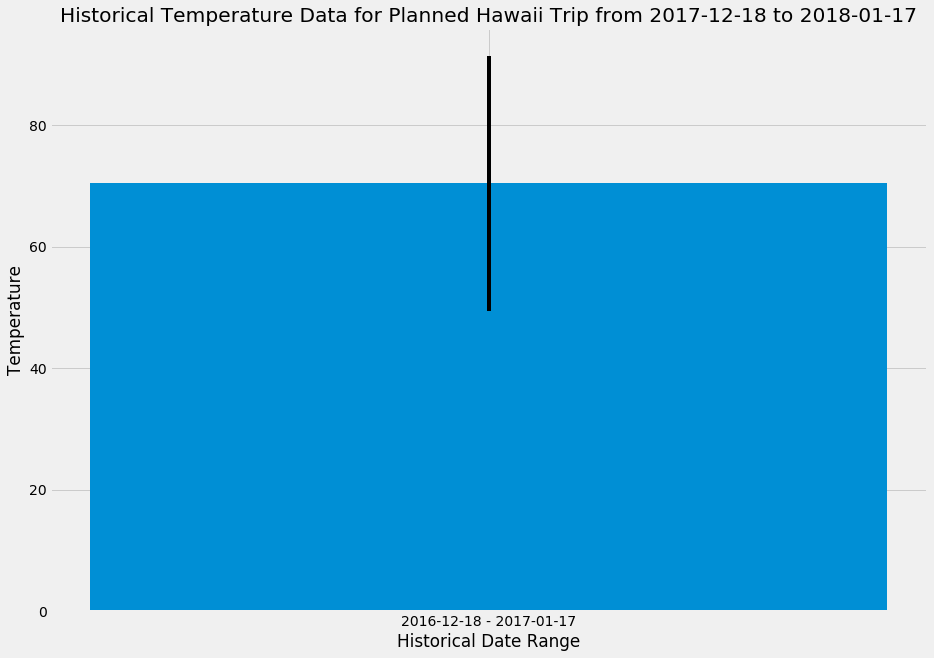

In [42]:
#Plot Bar Chart of Temperature Summary Data for Year Prior Trip Dates
plt.bar(0, prior_summary[0][1], yerr = prior_summary[0][2] - prior_summary[0][0])
plt.xticks([0], [prior_start + ' - ' + prior_end])
plt.title('Historical Temperature Data for Planned Hawaii Trip from ' + trip_start + ' to ' + trip_end)
plt.xlabel('Historical Date Range')
plt.ylabel('Temperature')
plt.show()

In [43]:
#Extract Station Information & Rainfall Totals per Station for Year Prior Trip Dates
station_rainfall = engine.execute('SELECT Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, SUM(Measurement.prcp) AS rainfall_total FROM Measurement INNER JOIN Station ON Station.station = Measurement.station WHERE Measurement.date >= :start AND Measurement.date <= :end GROUP BY Measurement.station ORDER BY rainfall_total DESC', {'start': prior_start, 'end': prior_end})

#Display Station Information & Rainfall Totals per Station for Year Prior Trip Dates
for rainfall in station_rainfall:
    print(rainfall)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 10.93)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 3.2499999999999996)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.73)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.21)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 1.4300000000000002)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.38)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.06)


In [44]:
#Define Daily Normals Function to Query Database for all Historic Minimum/Average/Maximum Temperature Data for a Given Month & Day
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [45]:
#Define Month & Day of Trip Start & End Dates
start_md = dt.date(int(start_split[0]), int(start_split[1]), int(start_split[2]))
end_md = dt.date(int(end_split[0]), int(end_split[1]), int(end_split[2]))

#Define Blank List for All Dates During Trip
date_list = []

#Create List of All Month & Day Dates During Trip
for date in range(0, (end_md - start_md).days + 1):
    date_list.append(start_md + dt.timedelta(days = date))

#Define Blank List for Daily Normals for Trip Dates & Blank List for Trip Dates
trip_normals = []
trip_days = []

#Loop Through Trip Dates & Remove Year Value & Generate List of Daily Normals
for trip_date in date_list:
    trip_days.append(trip_date.strftime('%Y-%m-%d'))
    trip_split = trip_date.strftime('%y-%m-%d').split('-')
    
    trip_normals.append(daily_normals(trip_split[1] + '-' + trip_split[2])[0])
    
#Display List of Daily Normals for Trip Dates
trip_normals

[(63.0, 71.28, 77.0),
 (67.0, 72.0, 78.0),
 (65.0, 72.91304347826087, 81.0),
 (67.0, 72.13953488372093, 78.0),
 (67.0, 71.1304347826087, 77.0),
 (61.0, 70.34693877551021, 78.0),
 (62.0, 70.0625, 78.0),
 (60.0, 71.75, 79.0),
 (63.0, 71.44680851063829, 77.0),
 (62.0, 71.91666666666667, 79.0),
 (62.0, 70.52083333333333, 77.0),
 (57.0, 70.29166666666667, 78.0),
 (63.0, 69.86363636363636, 76.0),
 (56.0, 68.27906976744185, 77.0),
 (62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0),
 (62.0, 69.74137931034483, 77.0),
 (57.0, 67.3103448275862, 78.0),
 (57.0, 67.4074074074074, 81.0),
 (57.0, 67.25454545454545, 77.0),
 (58.0, 69.52631578947368, 77.0),
 (56.0, 69.31372549019608, 78.0),
 (54.0, 68.62962962962963, 80.0),
 (61.0, 69.07407407407408, 76.0)]

In [46]:
#Create Pandas Data Frame of Daily Normals for Trip Dates
normal_data = pd.DataFrame(trip_normals, columns = ['Minimum Temp', 'Average Temp', 'Maximum Temp'])

#Add Column to Data Frame for Trip Dates
normal_data['Date'] = trip_days

#Set Trip Date Column as Data Frame Index
normal_data = normal_data.set_index('Date')

#Display Data Frame of Daily Normals for Trip Dates
normal_data

,Minimum Temp,Average Temp,Maximum Temp
Date,,,
2016-12-18,63.0,71.280000,77.0
2016-12-19,67.0,72.000000,78.0
2016-12-20,65.0,72.913043,81.0
2016-12-21,67.0,72.139535,78.0
2016-12-22,67.0,71.130435,77.0
2016-12-23,61.0,70.346939,78.0
2016-12-24,62.0,70.062500,78.0
2016-12-25,60.0,71.750000,79.0
2016-12-26,63.0,71.446809,77.0


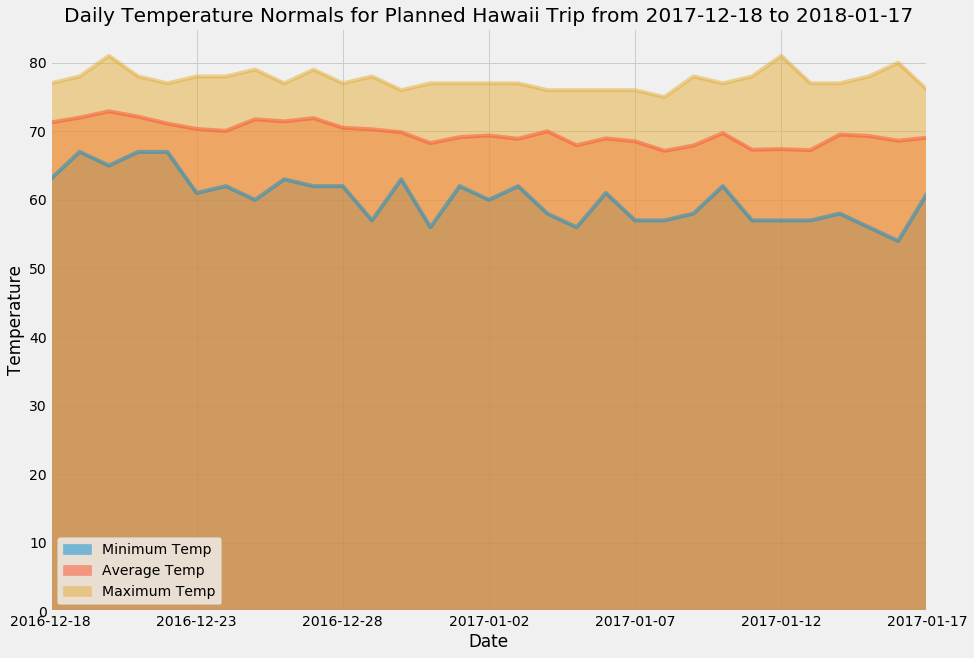

In [51]:
#Generate Area Plot of Daily Normals for Trip Dates
normal_data.plot.area(stacked = False)
plt.title('Daily Temperature Normals for Planned Hawaii Trip from ' + trip_start + ' to ' + trip_end)
plt.ylabel('Temperature')
plt.show()